In [1]:
import os
import numpy as np
import pandas as pd


#get data
from pydob.streeteasy import get_sales_data,get_rent_data
from pydob.exploratory import (
                    convert_year_month_to_labels,
                    convert_float_indices_to_int,
                    get_dataset_type_df,
                    violations_ecb_penalties_year_agg,
                    violations_ecb_year_counts,
                    savefig
            )

from pydob.build import build
from pydob.database import get_query_as_df
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pydob.settings import nt_style, nt_blue, nt_black
from indoorplants.analysis.exploratory import feature_value_counts_by_class

In [2]:
%matplotlib inline
plt.style.use(nt_style)

# 1.0 Violation Categorical Analysis

In [3]:
ecb_violations_type_to_plot = get_dataset_type_df(type_col='violation_type',
                                                  index_col='isn_dob_bis_extract',
                                                  year_col='issue_date_year',
                                                  dataset_name='violations_ecb')

In [4]:
ecb_violations_type_to_plot = ecb_violations_type_to_plot.loc[2006:2019]/1000

In [5]:
ecb_violations_type_to_plot = convert_float_indices_to_int(df=ecb_violations_type_to_plot)
ecb_violations_type_to_plot = ecb_violations_type_to_plot.reset_index(
                                                        ).set_index(['issue_date_year',
                                                                     'violation_type'])

In [6]:
ecb_violations_type = ecb_violations_type_to_plot.copy()

In [7]:
top_3_types = ecb_violations_type_to_plot.groupby(
                                            level='issue_date_year'
                                        ).apply(
                                            lambda x: x.nlargest(3, columns=['isn_dob_bis_extract'])
                                        ).reset_index(
                                            level=0, drop=True)

top_3_types = top_3_types.unstack()
top_3_types.columns = top_3_types.columns.droplevel()

In [8]:
ecb_violations_type_to_plot = ecb_violations_type_to_plot.unstack(1)

In [9]:
ecb_violations_type_to_plot.columns = ecb_violations_type_to_plot.columns.droplevel(0)

In [10]:
top_3_types = ecb_violations_type_to_plot[top_3_types.columns]

In [11]:
violations_labels =  top_3_types.columns.to_list()

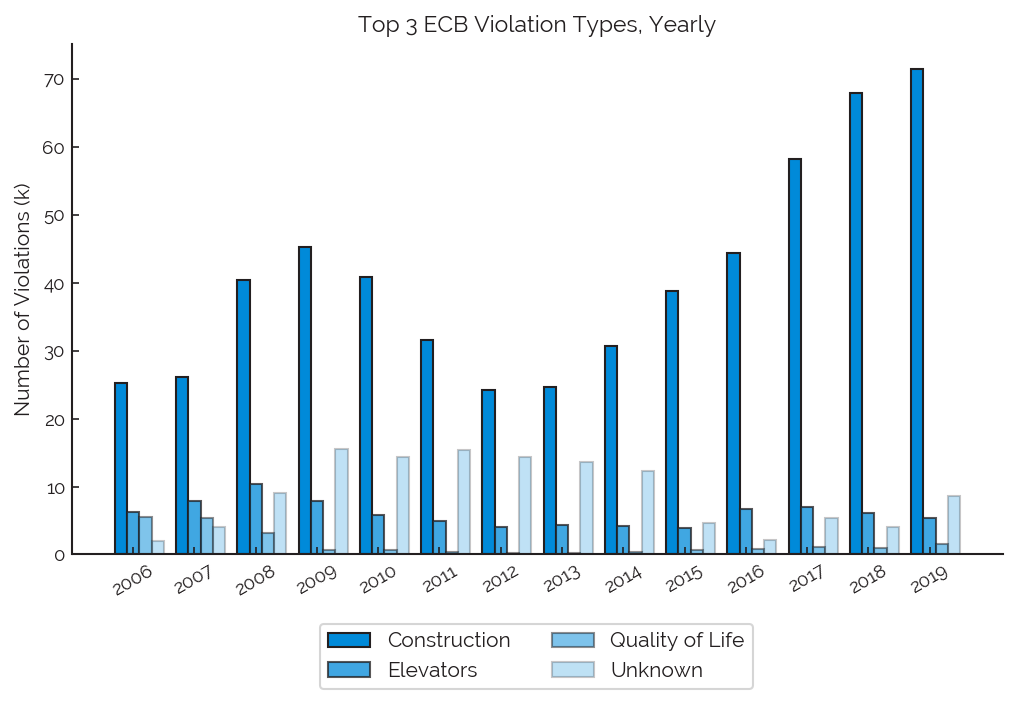

In [12]:
# ticks
fig, ax = plt.subplots()

x1 = np.linspace(0,13,(2019-2006)+1)*5
x2 = np.linspace(0,13,(2019-2006)+1)*5+1
x3 = np.linspace(0,13,(2019-2006)+1)*5+2
x4 = np.linspace(0,13,(2019-2006)+1)*5+3

x = [x1,x2,x3,x4]

# plotting
for i,c in enumerate(violations_labels):
    plt.bar(x= x[i],
            height=top_3_types[c], 
            width = 1, 
            color=nt_blue,
            edgecolor = nt_black,
            label = c, 
            alpha = 1-0.25*i )
# legend
l = plt.legend(loc='center left', 
           bbox_to_anchor=(.255, -0.2),
           fancybox=True,
           shadow=False, 
           ncol=2)

#label
plt.xticks(ticks=x2, labels=top_3_types.index,rotation=30)
lab = plt.ylabel("Number of Violations (k)")
lab = plt.xlabel(None)

title= plt.title('Top 3 ECB Violation Types, Yearly')

savefig("violation_types.png", fig, bottom=.2)

In [13]:
top_3_types

violation_type,Construction,Elevators,Quality of Life,Unknown
issue_date_year,,,,
2006,25.230,6.217,5.475,2.040
2007,26.208,7.923,5.385,4.113
2008,40.431,10.373,3.161,9.052
2009,45.217,7.888,0.627,15.514
2010,40.791,5.757,0.604,14.334
2011,31.625,4.972,0.363,15.344
2012,24.287,4.065,0.163,14.305
2013,24.700,4.276,0.252,13.566
2014,30.764,4.216,0.429,12.234


**Notes:**
- Violations from `Construction` soars over the years
- `Elevators` 
- Interesting to see `unknown` picking up since 2008
- Need to further investigate `unknown` 

# 2.0 Violation Penatly Analysis

#### 1. overview

- avg and std dev penalty (over the course of a month) over time - could be a line plot of avg with bands for std dev
- for top-3 violations analysis, avg and std penalty over time (this might be better as just a table)
- penalty imposed / amount paid ? this would ber updated periodically, presumably, but it could be good to have an index of sorts to track the DoB's effectiveness at collection
- autocorrelation check here, too


##  2.1 Penalty Imposed Mean Median

In [14]:
ecb_penalty_penality_imposed_issue = violations_ecb_penalties_year_agg(
                                                agg_method_or_methods=[np.mean,np.median],
                                                filter_year=2000,
                                                to_group_by="issue_date_year")['penality_imposed'].loc[2000:2019]


ecb_penalty_penality_paid_issue = violations_ecb_penalties_year_agg(
                                                agg_method_or_methods=[np.mean,np.median],
                                                filter_year=2000,
                                                to_group_by="issue_date_year")['amount_paid'].loc[2000:2019]


ecb_penalty_penality_imposed_hearing = violations_ecb_penalties_year_agg(
                                                agg_method_or_methods=[np.mean,np.median],
                                                filter_year=2000,
                                                to_group_by="hearing_date_year")['penality_imposed'].loc[2000:2019]

ecb_penalty_penality_paid_hearing =  violations_ecb_penalties_year_agg(
                                                agg_method_or_methods=[np.mean,np.median],
                                                filter_year=2000,
                                                to_group_by="hearing_date_year")['amount_paid'].loc[2000:2019]


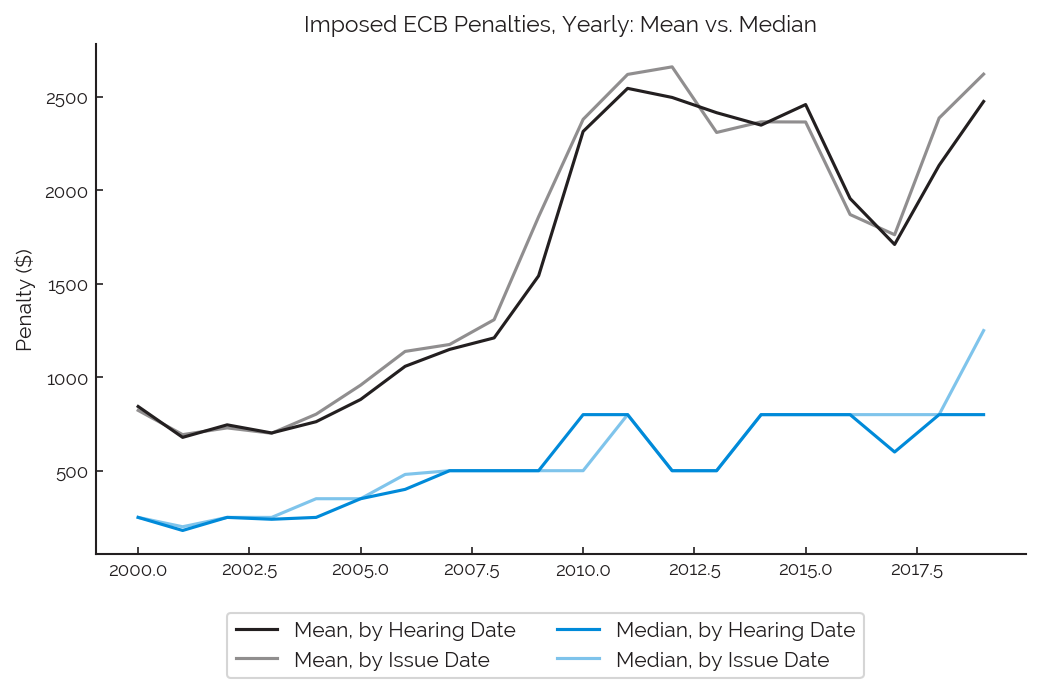

In [15]:

fig, ax = plt.subplots()

ax.xaxis.set_major_locator(plt.MaxNLocator(10))

ax = ecb_penalty_penality_imposed_hearing["mean"].plot(ax=ax, color=nt_black, label="Mean, by Hearing Date")
ax = ecb_penalty_penality_imposed_issue["mean"].plot(ax=ax, color=nt_black, label="Mean, by Issue Date", alpha = 0.5)
ax = ecb_penalty_penality_imposed_hearing["median"].plot(ax=ax, color=nt_blue, label="Median, by Hearing Date")
ax = ecb_penalty_penality_imposed_issue["median"].plot(ax=ax, color=nt_blue, label="Median, by Issue Date",  alpha = 0.5)

xlab = ax.set_xlabel(None)
ylab = ax.set_ylabel("Penalty ($)")

l = plt.legend(loc='center left', 
           bbox_to_anchor=(.13, -0.18),
           fancybox=True,
           shadow=False, 
           ncol=2)

t = ax.title.set_text("Imposed ECB Penalties, Yearly: Mean vs. Median")

savefig("penalty_imposed_y_hearing_issue.png", fig, bottom=.2)

##  2.2 Penalty Paid Mean Median

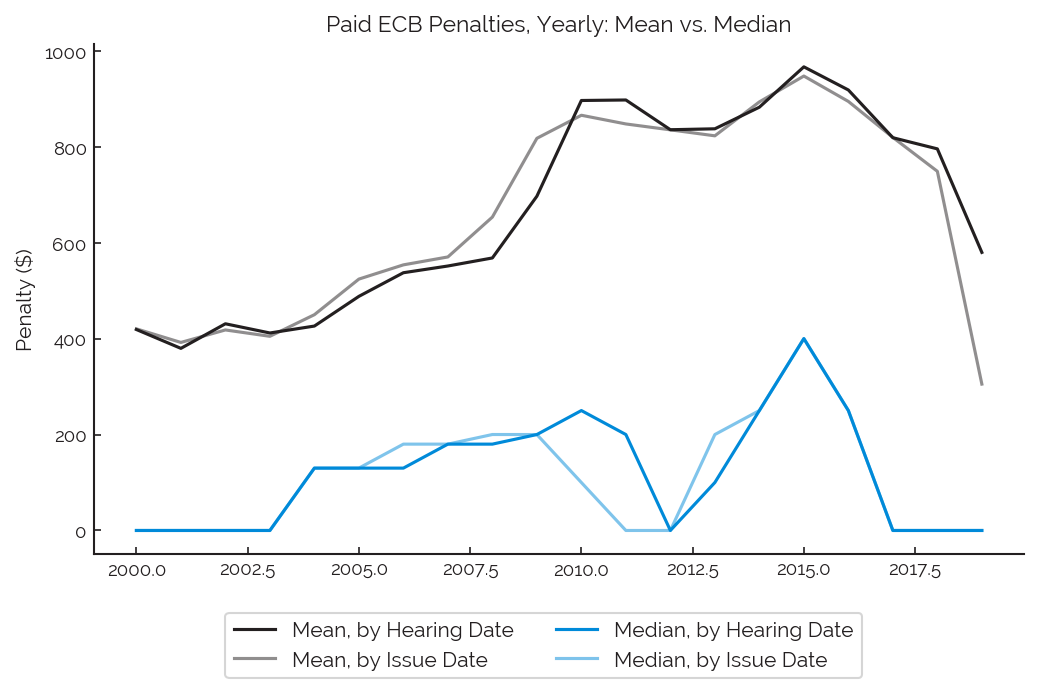

In [16]:
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(plt.MaxNLocator(10))

ax = ecb_penalty_penality_paid_hearing["mean"].plot(ax=ax, color=nt_black, label="Mean, by Hearing Date")
ax = ecb_penalty_penality_paid_issue["mean"].plot(ax=ax, color=nt_black, label="Mean, by Issue Date", alpha = 0.5)
ax = ecb_penalty_penality_paid_hearing["median"].plot(ax=ax, color=nt_blue, label="Median, by Hearing Date")
ax = ecb_penalty_penality_paid_issue["median"].plot(ax=ax, color=nt_blue, label="Median, by Issue Date",  alpha = 0.5)

xlab = ax.set_xlabel(None)
ylab = ax.set_ylabel("Penalty ($)")

l = plt.legend(loc='center left', 
           bbox_to_anchor=(.13, -0.18),
           fancybox=True,
           shadow=False, 
           ncol=2)

t = ax.title.set_text("Paid ECB Penalties, Yearly: Mean vs. Median")

savefig("penalty_paid_y_hearing_issue.png", fig, bottom=.2)

## 2.3 Paid to Imposed Ratio

In [17]:
violations_ecb_counts_issue_year = violations_ecb_year_counts()
violations_ecb_counts_issue_year = violations_ecb_counts_issue_year.loc[2000:2019]
violations_ecb_counts_issue_year.columns = ['violations']

In [18]:
ecb_penalty_sum_hearing = violations_ecb_penalties_year_agg(
                                                agg_method_or_methods=[np.sum],
                                                to_group_by="hearing_date_year")

In [19]:
ecb_penalty_sum_hearing.columns = ecb_penalty_sum_hearing.columns.droplevel(1)

In [20]:
ecb_penalty_sum_hearing["ratio"] = ecb_penalty_sum_hearing.amount_paid / ecb_penalty_sum_hearing.penality_imposed

In [21]:
ecb_penalty_sum_hearing = ecb_penalty_sum_hearing.reset_index()
ecb_penalty_sum_hearing['hearing_date_year'] = ecb_penalty_sum_hearing.hearing_date_year.astype(int)
ecb_penalty_sum_hearing = ecb_penalty_sum_hearing.set_index('hearing_date_year')

In [22]:
table_to_plot = ecb_penalty_sum_hearing.join(violations_ecb_counts_issue_year)

In [23]:
table_to_plot.ratio = table_to_plot.ratio*100
table_to_plot.violations = table_to_plot.violations/1000

In [24]:
table_to_plot = table_to_plot.loc[:2019]

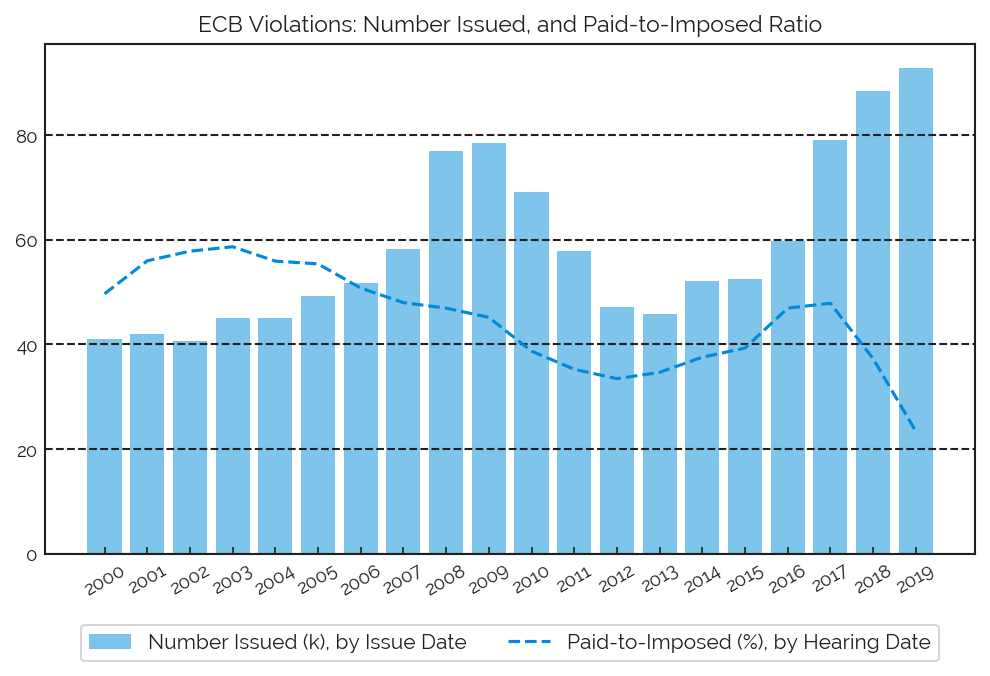

In [27]:
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(plt.FixedLocator(table_to_plot.index))
# ax = (ecb_penalty_sum.ratio).plot(ax=ax, color=nt_blue)
ax.plot(table_to_plot.index, 
         table_to_plot["ratio"], 
         color=nt_blue, 
         linestyle = '--',
         label='Paid-to-Imposed (%), by Hearing Date')

ax.bar(table_to_plot.index, 
       table_to_plot["violations"], 
       color=nt_blue, 
       label='Number Issued (k), by Issue Date',
       alpha = 0.5)


xlab = ax.set_xlabel(None)
# ylab = ax.set_ylabel("Ratio (%)")
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[::-1], 
          labels[::-1],
          loc='center left', 
          bbox_to_anchor=(0.0275, -0.175),
          fancybox=True,
          shadow=False, 
          ncol=2)

ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
# formating grid line
ax.grid(axis="y", color=nt_black, linestyle="--", linewidth=1)
ax.set_xticklabels(table_to_plot.index,rotation=30)
t = ax.title.set_text("ECB Violations: Number Issued, and Paid-to-Imposed Ratio")

savefig("penalty_paid_to_imposed_yearly.png", fig, bottom=.2)

In [28]:
table_to_plot

,penality_imposed,amount_paid,ratio,violations
hearing_date_year,,,,
2000,3.280294e+07,16289502.27,49.658669,41.030
2001,2.964283e+07,16589459.18,55.964492,42.059
2002,2.983385e+07,17246260.74,57.807694,40.566
2003,3.184802e+07,18680098.69,58.653883,45.041
2004,3.456042e+07,19321675.54,55.906938,44.962
2005,4.076989e+07,22579586.20,55.382991,49.196
2006,5.128145e+07,26028716.33,50.756594,51.687
2007,6.009597e+07,28832429.37,47.977312,58.225
2008,7.875132e+07,36950961.55,46.921069,76.940


## 2.4  Proportion of Violations, Proportion of dollar penalty


- next steps
- look at nonpayment of ECB violations by violation type - e.g. get top 3 n_smallest  paid_to_imposed each year and plot. Let's see if there's a particular violation type that's going unpaid.


In [29]:
sql = """
        select 
            isn_dob_bis_extract, violation_type, penality_imposed, 
            amount_paid, hearing_date_month, hearing_date_year ,issue_date_year 
        from violations_ecb"""
violations_ecb= get_query_as_df(sql)
violations_ecb = violations_ecb.loc[violations_ecb.hearing_date_year >= 2000]
violations_ecb[['hearing_date_month','hearing_date_year']] = violations_ecb[['hearing_date_month',
                                                                             'hearing_date_year']].astype(int)

### by Violation Type by year

In [30]:
penalties_by_year = violations_ecb[
                            ["hearing_date_year", 
                             "violation_type", 
                             "penality_imposed", 
                             "amount_paid"]
                                    ].groupby(
                             ["hearing_date_year", 
                              "violation_type"]
                                    ).sum()

In [31]:
counts_by_year = violations_ecb[
                            ["issue_date_year", 
                             "violation_type", 
                             "isn_dob_bis_extract", ]
                                    ].groupby(
                             ["issue_date_year", 
                              "violation_type"]
                                    ).count()
counts_by_year.columns =['counts']

In [32]:
counts_by_year.head()

counts
issue_date_year violation_type        
1979            Elevators            1
1980            Construction         2
                Elevators            1
1982            Plumbing             1
1984            Construction         2

In [33]:
counts_by_year['norm_counts'] = counts_by_year.counts.groupby(
                                                            level=0).transform(lambda x: (x / x.sum()).round(2))

In [34]:
counts_by_year.loc[2017:].loc[(slice(None), "Construction"), :]

,,counts,norm_counts
issue_date_year,violation_type,,
2017,Construction,58225,0.74
2018,Construction,67900,0.77
2019,Construction,71532,0.77
2020,Construction,456,0.64


In [35]:
penalties_by_year['imposed_percent'] = penalties_by_year.penality_imposed.groupby(
                                                            level=0).transform(lambda x: (x / x.sum()).round(2))

In [36]:
penalties_by_year['paid_percent'] = penalties_by_year.amount_paid.groupby(
                                                            level=0).transform(lambda x: (x / x.sum()).round(2))

In [37]:
penalties_by_year["paid_to_imposed"] = penalties_by_year.amount_paid / penalties_by_year.penality_imposed

In [38]:
result_17_19 = penalties_by_year.loc[2017:2019,[
                                                'imposed_percent',
                                                'paid_percent',
                                                'paid_to_imposed']].unstack(0)

In [39]:
result_17_19.columns = result_17_19.columns.swaplevel()

In [40]:
result_17_19.sort_index(axis=1, level=0, inplace=True)

In [41]:
result_17_19 = result_17_19.round(decimals=2).stack(0)

In [42]:
result_17_19

imposed_percent  paid_percent  \
violation_type      hearing_date_year                                  
Boilers             2017                          0.02          0.02   
                    2018                          0.01          0.01   
                    2019                          0.01          0.01   
Construction        2017                          0.78          0.74   
                    2018                          0.80          0.74   
                    2019                          0.76          0.71   
Cranes and Derricks 2017                          0.01          0.01   
                    2018                          0.01          0.02   
                    2019                          0.01          0.01   
Elevators           2017                          0.04          0.07   
                    2018                          0.03          0.04   
                    2019                          0.03          0.05   
HPD                 2017                          0.00          0.00   
Local Law           2017                          0.01          0.02   
                    2018                          0.01          0.01   
                    2019                          0.01          0.03   
Plumbing            2017                          0.02          0.02   
                    2018                          0.01          0.02   
                    2019                          0.01          0.01   
Public Assembly     2017                          0.00          0.00   
                    2018                          0.00          0.00   
                    2019                          0.00          0.00   
Quality of Life     2017                          0.03          0.03   
                    2018                          0.04          0.03   
                    2019                          0.09          0.03   
Signs               2017                          0.01          0.01   
                    2018                          0.02          0.02   
                    2019                          0.01          0.01   
Site Safety         2017                          0.00          0.00   
                    2018                          0.00          0.00   
                    2019                          0.01          0.01   
Unknown             2017                          0.06          0.08   
                    2018                          0.06          0.09   
                    2019                          0.07          0.12   
Zoning              2017                          0.00          0.01   
                    2018                          0.01          0.01   
                    2019                          0.00          0.01   
Administrative      2018                          0.00          0.00   

                                       paid_to_imposed  
violation_type      hearing_date_year                   
Boilers             2017                          0.43  
                    2018                          0.43  
                    2019                          0.34  
Construction        2017                          0.45  
                    2018                          0.34  
                    2019                          0.22  
Cranes and Derricks 2017                          0.83  
                    2018                          0.81  
                    2019                          0.41  
Elevators           2017                          0.72  
                    2018                          0.49  
                    2019                          0.43  
HPD                 2017                          0.00  
Local Law           2017                          0.66  
                    2018                          0.49  
                    2019                          0.51  
Plumbing            2017                          0.58  
                    2018                          0.46  
                  

## 2.5 Penalty paid to imposed ratio by buckets of imposed dollar value

In [43]:
paid_to_imposed_data = violations_ecb[['penality_imposed','amount_paid','hearing_date_year']].copy()

In [44]:
bins_test = paid_to_imposed_data.penality_imposed.value_counts().to_frame()
bins_test = bins_test.sort_index().reset_index()
bins_test.columns = ['penalty','counts']

In [45]:
paid_to_imposed_data['bins'] = pd.cut(paid_to_imposed_data.penality_imposed,
                                      [0, 500, 1000, 5000, 10000, 50000, 100000])

In [46]:
def paid_to_imposed(df):
    return df.amount_paid.sum() / df.penality_imposed.sum()

In [47]:
paid_to_imposed_binned = paid_to_imposed_data[
    (paid_to_imposed_data.hearing_date_year>2015)
    & (paid_to_imposed_data.penality_imposed> 0)
    & (paid_to_imposed_data.hearing_date_year < 2020)
                    ].groupby(['hearing_date_year','bins']
                    ).apply(paid_to_imposed).rename("paid_to_imposed"
                    ).to_frame()

In [48]:
paid_to_imposed_binned = paid_to_imposed_binned*100

In [49]:
paid_to_imposed_binned_to_plot = paid_to_imposed_binned.unstack()

In [50]:
paid_to_imposed_binned_to_plot.columns = paid_to_imposed_binned_to_plot.columns.droplevel()

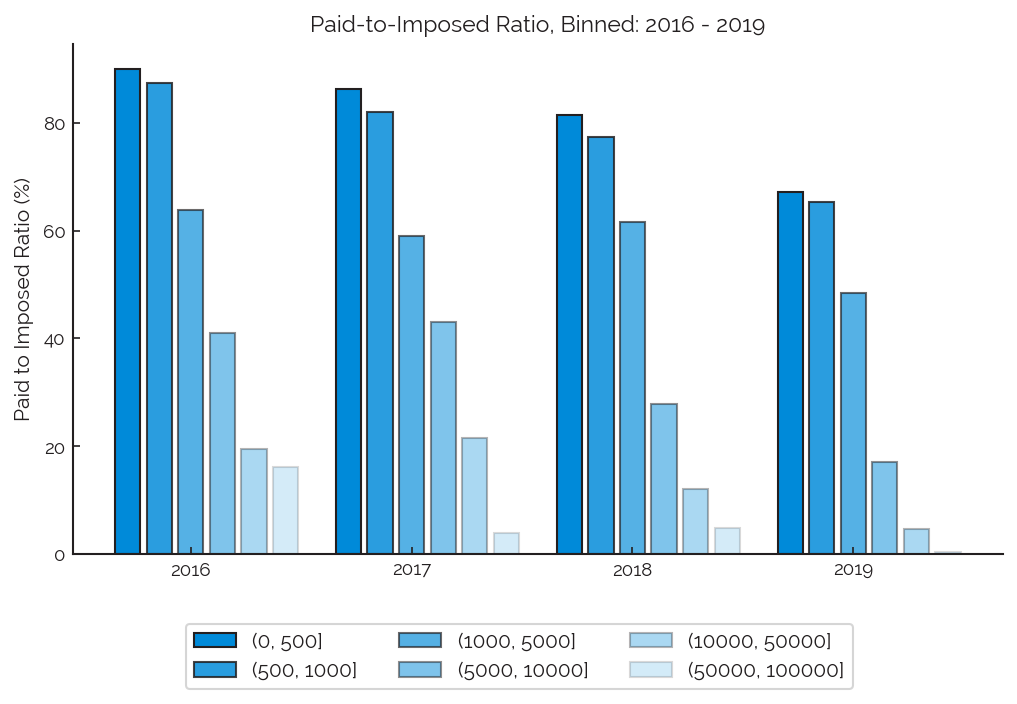

In [51]:
fig, ax = plt.subplots()

x1 = np.linspace(0,3,(2019-2016)+1)*7
x2 = np.linspace(0,3,(2019-2016)+1)*7+1
x3 = np.linspace(0,3,(2019-2016)+1)*7+2
x4 = np.linspace(0,3,(2019-2016)+1)*7+3
x5 = np.linspace(0,3,(2019-2016)+1)*7+4
x6 = np.linspace(0,3,(2019-2016)+1)*7+5

x = [x1,x2,x3,x4,x5,x6]

# plotting
for i,c in enumerate(paid_to_imposed_binned_to_plot.columns):
    plt.bar(x= x[i],
            height=paid_to_imposed_binned_to_plot[c], 
            width = 0.8, 
            color=nt_blue,
            edgecolor = nt_black,
            label = c, 
            alpha = 1-(1 / 6)*i )

# legend
l = plt.legend(loc='center left', 
           bbox_to_anchor=(.11, -0.2),
           fancybox=True,
           shadow=False, 
           ncol=3)

#label
plt.xticks(ticks=x3, labels=paid_to_imposed_binned_to_plot.index,rotation=0)
lab = plt.ylabel("Paid to Imposed Ratio (%)")
lab = plt.xlabel(None)

t = ax.set_title('Paid-to-Imposed Ratio, Binned: 2016 - 2019')
savefig("paid_to_imposed_bins.png", fig, bottom=.2)

In [52]:
paid_to_imposed_binned_to_plot

bins,"(0, 500]","(500, 1000]","(1000, 5000]","(5000, 10000]","(10000, 50000]","(50000, 100000]"
hearing_date_year,,,,,,
2016,89.959553,87.277110,63.722627,41.092119,19.575326,16.121714
2017,86.242135,81.987317,59.067698,43.057869,21.543053,3.979885
2018,81.402043,77.379626,61.629957,27.893900,12.103294,4.879977
2019,67.176280,65.304715,48.510967,17.165930,4.793826,0.449684


# 3.0 `Hearing_status` - Dismissed and Written Off with Median Sales Price

**next steps for hearings analysis**

- what are the mean and std of the delta between hearing date and issuance date, by issuance year, from 2000 - 2019?
- what % of positive-dollar-value-penalty'd violations have a hearing date?
- how does 2. look year-over-issuance-year, 2000-2019
- histograms of $imposed, $paid, hearing-issuance date delta, for 2019



**Office of Administrative Trials and Hearings**

The Office of Administrative Trials and Hearings/Environmental Control Board (OATH) is an administrative tribunal that provides hearings on notices of violation issued by City agencies. As a judicial entity, OATH does not issue notices of violation, does not establish enforcement policies, does not employ inspectors or agents, and does not direct, control or otherwise influence where, when or to who notices are issued.

OATH has an office for hearings in each borough. All cases are prescheduled. Walk-ins are not allowed, except to admit or stipulate to a violation prior to or on the initial hearing date.

In [53]:
sql = '''
         select isn_dob_bis_extract,
                hearing_date,
                issue_date, 
                issue_date_year,
                violation_type, 
                penality_imposed, 
                amount_paid, 
                hearing_date_year, 
                hearing_date_month,
                hearing_status,
                ecb_violation_status
         from violations_ecb 
         where hearing_date_year >= 2000 and
               hearing_date_year <= 2019
         '''
hearing_date_table= get_query_as_df(sql)
hearing_date_table[['hearing_date_year',
                    'hearing_date_month']] = hearing_date_table.reset_index(
                                                    )[['hearing_date_year',
                                                       'hearing_date_month']].astype(int)
hearing_date_table['diff_hear_issue'] = hearing_date_table.hearing_date-hearing_date_table.issue_date
hearing_date_table['diff_hear_issue'] = hearing_date_table['diff_hear_issue'].dt.days

In [54]:
streeteasy_sales = get_sales_data()

streeteasy_nyc_sales = streeteasy_sales.loc['NYC','median_sales_price'].to_frame()

streeteasy_nyc_sales_year = streeteasy_nyc_sales.groupby(level = 0).apply(lambda x: x.median()).loc[:2019]
streeteasy_nyc_sales_year['median_sales_price'] = streeteasy_nyc_sales_year.median_sales_price /1000

In [55]:
dismissed_or_witoff = hearing_date_table[((hearing_date_table.hearing_status == 'DISMISSED'
                                               ) | (hearing_date_table.hearing_status == 'WRITTEN OFF')
                                                 ) &(hearing_date_table.penality_imposed == 0)]

In [56]:
dismiss_witoff_to_plot = dismissed_or_witoff[['isn_dob_bis_extract',
                                'hearing_date_year',
                                'hearing_status'
                                     ]].groupby(
                                ['hearing_date_year','hearing_status']
                                      ).count().unstack()
dismiss_witoff_to_plot.columns = dismiss_witoff_to_plot.columns.droplevel()
dismiss_witoff_to_plot = dismiss_witoff_to_plot.fillna(0)/1000

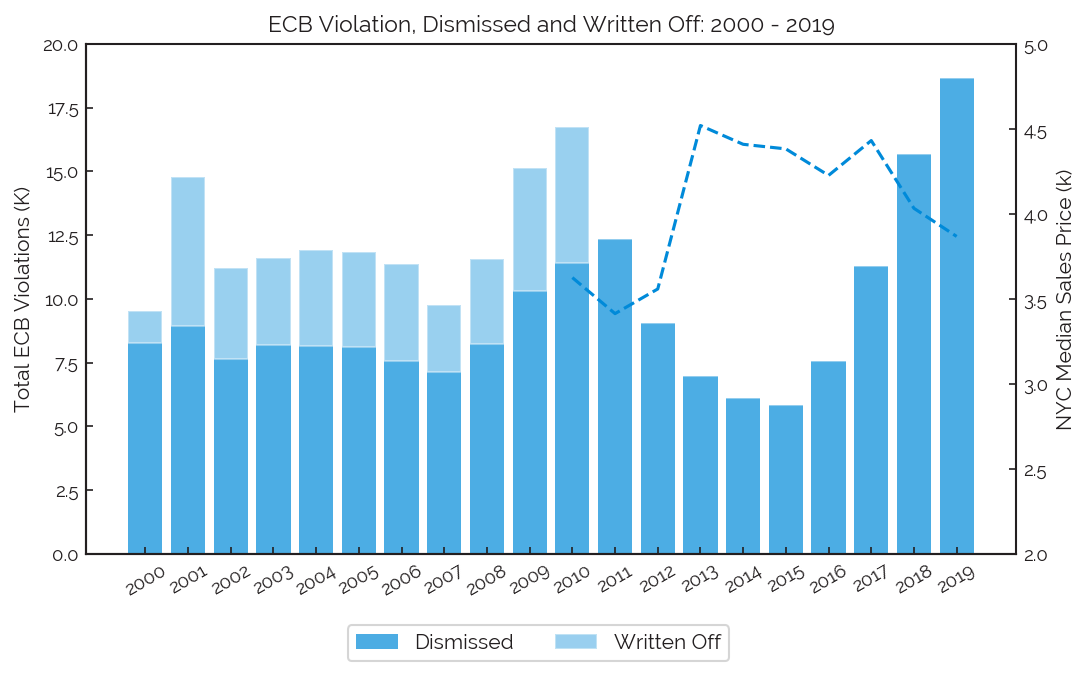

In [57]:
fig, ax1 = plt.subplots()

x = dismiss_witoff_to_plot.index
ax2 = ax1.twinx()

ax1.bar(x, 
        dismiss_witoff_to_plot['DISMISSED'],
        color = nt_blue, 
        alpha = 0.7,
        width=0.8, 
        label = 'Dismissed')

ax1.bar(x, 
        dismiss_witoff_to_plot['WRITTEN OFF'], 
        bottom=dismiss_witoff_to_plot['DISMISSED'], 
        color=nt_blue,
        alpha = 0.4, 
        edgecolor='white',
        width=0.8, 
        label = 'Written Off')

ylim = ax1.set_ylim([0,20])

ax2.plot(x[10:],
         streeteasy_nyc_sales_year.median_sales_price,
         color = nt_blue, 
         linestyle = '--', 
         label = 'Median Sales Price')

ylim = ax2.set_ylim([2,5])

ax1.spines["top"].set_visible(True)
ax1.spines["right"].set_visible(True)

ax1.set_xticklabels(dismiss_witoff_to_plot.index,rotation=30)
ax1.set_xticks(dismiss_witoff_to_plot.index )

ax1.legend(loc='center left', 
           bbox_to_anchor=(0.27, -0.175),
           fancybox=True,
           shadow=False, 
           ncol=3)

ax1.set_ylabel('Total ECB Violations (K)')
ax2.set_ylabel('NYC Median Sales Price (k)')

t = ax1.set_title("ECB Violation, Dismissed and Written Off: 2000 - 2019")
savefig("dismissed_writtenoff_ecb.png", fig, bottom=.2)

In [58]:
hearing_date_table.hearing_status.value_counts()

IN VIOLATION          466643
DISMISSED             187579
WRITTEN OFF           144230
CURED/IN-VIO          126916
DEFAULT               112229
STIPULATION/IN-VIO     66326
POP/IN-VIO             31249
ADMIT/IN-VIO           12307
PENDING                  296
Name: hearing_status, dtype: int64

# 4.0 ECB Violations Status Analysis

- `ecb_violation_status`: Indicates whether or not the violation has been corrected. This is the status of the violation with DOB, not the status of the hearing with OATH.

    - ACTIVE - still needs to be addressed

    - RESOLVE - the issue was either fixed with DOB or dismissed by OATH

In [59]:
active_violations = hearing_date_table[hearing_date_table.ecb_violation_status == 'ACTIVE']

In [60]:
active_violations_counts = active_violations[[
                                    'isn_dob_bis_extract',
                                    'hearing_date_year'
                                            ]].groupby([
                                    'hearing_date_year'
                                            ]).count().loc[:2019]

In [61]:
total_violations_counts = hearing_date_table[[
                                    'isn_dob_bis_extract',
                                    'hearing_date_year'
                                            ]].groupby([
                                    'hearing_date_year'
                                            ]).count().loc[:2019]

In [62]:
resolved_violations_counts = total_violations_counts - active_violations_counts

In [63]:
resolved_violations_counts.columns = ['resolved_counts']

In [64]:
active_violations_counts.columns = ['active_counts']

In [65]:
total_violations_counts.columns = ['total_counts']

In [66]:
counts_to_plot=active_violations_counts.join(resolved_violations_counts)

In [67]:
counts_to_plot['active_ratio'] = 100*active_violations_counts.active_counts/total_violations_counts.total_counts

In [68]:
counts_to_plot['active_counts'] = counts_to_plot.active_counts/1000
counts_to_plot['resolved_counts'] = counts_to_plot.resolved_counts/1000

In [69]:
counts_to_plot.to_csv('counts_to_plot.csv')

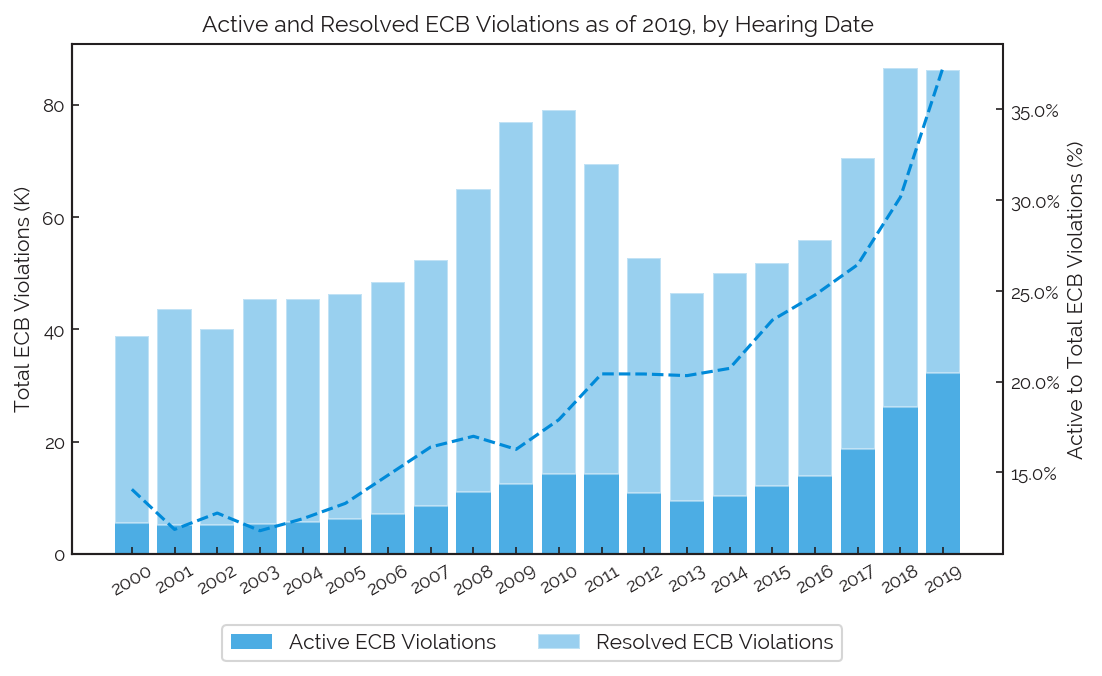

In [70]:
fig, ax1 = plt.subplots()

x = counts_to_plot.index

ax2 = ax1.twinx()

ax1.bar(x, 
        counts_to_plot.active_counts,
        color = nt_blue, 
        alpha = 0.7,
        width=0.8, 
        label = 'Active ECB Violations')

ax1.bar(x, 
        counts_to_plot.resolved_counts, 
        bottom=counts_to_plot.active_counts, 
        color=nt_blue,
        alpha = 0.4, 
        edgecolor='white',
        width=0.8, 
        label = 'Resolved ECB Violations')

ax2.plot(x, 
         counts_to_plot.active_ratio,
         color = nt_blue, 
         linestyle = '--')

ax1.spines["top"].set_visible(True)
ax1.spines["right"].set_visible(True)

ax1.set_xticklabels(counts_to_plot.index,rotation=30)
ax1.set_xticks(counts_to_plot.index )

ax1.legend(loc='center left', 
           bbox_to_anchor=(0.15, -0.175),
           fancybox=True,
           shadow=False, 
           ncol=2)
ylabs = ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%s%%'))

ax1.set_ylabel('Total ECB Violations (K)')
ax2.set_ylabel('Active to Total ECB Violations (%)')

t = ax1.set_title("Active and Resolved ECB Violations as of 2019, by Hearing Date")

savefig("active_resolved_ecb.png", fig, bottom=.2)

**Notes:**
- ECB Violations is picking up since 2013
- As of 2019, there are still more than 10% of ECB Violations that have not been resolved. Here we are grouping the counts of violations by `hearing_date`, which is the date that the violation case was brought to the court. 

- `hearing_date`: Date of the latest scheduled hearing for the respondent named on the violation to admit to it or contest the violation.
- It would be interesting to see what types of ECB Violations are active. 

- What is an HPD violation? An HPD violation is issued based on an infraction of the housing code. Violations are either issued by an inspector in response to a complaint, or administratively. HPD violations are not heard through the ECB, and have their own requirements for resolution.

# 5.0 `hearing_status` analysis

In [71]:
hearing_date_table.hearing_status.value_counts(dropna=False)

IN VIOLATION          466643
DISMISSED             187579
WRITTEN OFF           144230
CURED/IN-VIO          126916
DEFAULT               112229
STIPULATION/IN-VIO     66326
POP/IN-VIO             31249
ADMIT/IN-VIO           12307
NaN                     3400
PENDING                  296
Name: hearing_status, dtype: int64

**Notes:**
- `IN VIOLATION`:
- `POP/IN-VIO`: what is this hearing status? Seems like it never been paid. Need to further look how many of them in the dataset and how much of them accounts to the penalty.

- `STIPULATION/IN-VIO`: Admission of guilt – extends compliance time by an additional 75 days from the first scheduled hearing date

- `PENDING`: 
- `DEFAULT`: Respondent failed to appear for scheduled hearing and did not pay the summons prior to the hearing
- `CURED/IN-VIO`: Enforcement agency notes indicate that the violating conditions have been corrected prior to hearing

- `WRITTEN OFF`: Summons has been written off and nothing is due

- `DEFAULT`: Respondent failed to appear for scheduled hearing and did not pay the summons prior to the hearing

- `DISMISSED`: Dismissal – No Penalty Imposed; If you prevail in contesting your violation, you will not owe any penalties and your violation will be dismissed. However, the Department may re-inspect, reissue a violation, or appeal the decision.


- It seems like `POP/IN-VIO	`, `PENDING`, and `DEFAULT` are three major types where the penalties could not be collected. 

In [72]:
hearing_status_paid_imposed = hearing_date_table[[
                                    'hearing_date_year',
                                    'hearing_status',
                                    'penality_imposed',
                                    'amount_paid'
                                                ]].groupby([
                                    'hearing_date_year',
                                    'hearing_status'
                                                ]).apply(
                                                lambda x: x.amount_paid.sum(
                                                )/x.penality_imposed.sum())

/Users/francescao/projects/nyc_dob_analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/francescao/projects/nyc_dob_analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [73]:
hearing_status_paid_imposed = hearing_status_paid_imposed.to_frame()
hearing_status_paid_imposed.columns = ['paid_to_imposed']


In [74]:
hearing_status_paid_imposed_nsmallest = hearing_status_paid_imposed.reset_index().set_index([
                                         'hearing_date_year',
                                         'hearing_status'
                                       ]).groupby(
                                                level=['hearing_date_year']
                                        ).apply(
                                                lambda x: x.nsmallest(5, columns=['paid_to_imposed'])
                                        ).reset_index(
                                                level=0, 
                                                drop=True)

In [75]:
hearing_status_dollar = hearing_date_table[[
                                    'hearing_date_year',
                                    'hearing_status',
                                    'penality_imposed',
                                                ]].groupby(
                                    ['hearing_date_year',
                                    'hearing_status']
                                                 ).agg([np.sum,np.mean,np.median,np.std])
hearing_status_dollar.columns = hearing_status_dollar.columns.droplevel(level = 0)
hearing_status_dollar.columns = ['sum_penalty_imposed','mean_penalty_imposed',
                                 'median_penalty_imposed','std_penalty_imposed']

In [76]:
hearing_status_dollar_prop = hearing_date_table[[
                                    'hearing_date_year',
                                    'hearing_status',
                                    'penality_imposed',
                                                ]].groupby(
                                    ['hearing_date_year',
                                    'hearing_status']
                                                 ).sum(
                                                 ).groupby(level=0
                                                 ).transform(lambda x: (x/x.sum()).round(4))
hearing_status_dollar_prop.columns = ["norm_penalty_imposed"]


In [77]:
hearing_status_viol = hearing_date_table[[
                            'hearing_date_year',
                            'hearing_status',
                            'isn_dob_bis_extract',
                                        ]].groupby(
                            ['hearing_date_year',
                            'hearing_status']
                                         ).count()
hearing_status_viol.columns = ["violation_counts"]

In [78]:
hearing_status_viol_prop = hearing_date_table[[
                                    'hearing_date_year',
                                    'hearing_status',
                                    'isn_dob_bis_extract',
                                                ]].groupby(
                                    ['hearing_date_year',
                                    'hearing_status']
                                                 ).count(
                                                 ).groupby(level=0
                                                 ).transform(lambda x: (x/x.sum()).round(4))
hearing_status_viol_prop.columns = ["norm_violation_counts"]

In [79]:
hearing_status_agg =  hearing_status_dollar.join(
                                                hearing_status_dollar_prop
                                          ).join(
                                                hearing_status_viol
                                          ).join(
                                                hearing_status_viol_prop
                                          ).join(
                                                hearing_status_paid_imposed)

In [80]:
hearing_status_agg.loc[2017].T.style.background_gradient(cmap='Purples',axis = 1)

/Users/francescao/projects/nyc_dob_analysis/env/lib/python3.7/site-packages/pandas/io/formats/style.py:1093: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))
/Users/francescao/projects/nyc_dob_analysis/env/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


hearing_status,ADMIT/IN-VIO,CURED/IN-VIO,DEFAULT,DISMISSED,IN VIOLATION,PENDING,POP/IN-VIO,STIPULATION/IN-VIO
sum_penalty_imposed,3057350.000000,22105.000000,58059965.000000,0.000000,51106558.000000,172500.000000,429040.000000,2018350.000000
mean_penalty_imposed,1571.094553,3.751697,6272.684205,0.000000,1586.963048,9078.947368,84.589905,503.203690
median_penalty_imposed,830.000000,0.000000,4000.000000,0.000000,1000.000000,12000.000000,0.000000,500.000000
std_penalty_imposed,2067.374870,73.339820,6002.004454,0.000000,2900.052231,5869.561686,878.152714,286.721224
norm_penalty_imposed,0.026600,0.000200,0.505500,0.000000,0.444900,0.001500,0.003700,0.017600
violation_counts,1946.000000,5892.000000,9256.000000,11307.000000,32204.000000,19.000000,5072.000000,4011.000000
norm_violation_counts,0.027900,0.084500,0.132800,0.162200,0.462000,0.000300,0.072800,0.057500
paid_to_imposed,1.020273,1.896918,0.174569,inf,0.753715,0.663402,0.002867,0.879210


In [81]:
hearing_status_agg.loc[2018].T.style.background_gradient(cmap='Purples',axis = 1)

hearing_status,ADMIT/IN-VIO,CURED/IN-VIO,DEFAULT,DISMISSED,IN VIOLATION,PENDING,POP/IN-VIO,STIPULATION/IN-VIO
sum_penalty_imposed,3525885.000000,15829.000000,94397622.500000,0.000000,79439174.000000,0.000000,504175.000000,2964185.000000
mean_penalty_imposed,1690.261266,2.229751,8392.391759,0.000000,1919.701651,0.000000,124.119892,686.471746
median_penalty_imposed,1280.000000,0.000000,6250.000000,0.000000,1250.000000,0.000000,0.000000,620.000000
std_penalty_imposed,1847.738110,45.642553,7577.014887,0.000000,3116.313421,0.000000,1225.307928,449.908778
norm_penalty_imposed,0.019500,0.000100,0.522000,0.000000,0.439300,0.000000,0.002800,0.016400
violation_counts,2086.000000,7099.000000,11248.000000,15679.000000,41381.000000,2.000000,4062.000000,4318.000000
norm_violation_counts,0.024300,0.082700,0.131000,0.182600,0.481900,0.000000,0.047300,0.050300
paid_to_imposed,1.005931,2.696993,0.072933,inf,0.668929,nan,0.000000,0.834781


In [82]:
hearing_status_agg.loc[2019].T.style.background_gradient(cmap='Purples',axis = 1)

hearing_status,ADMIT/IN-VIO,CURED/IN-VIO,DEFAULT,DISMISSED,IN VIOLATION,PENDING,POP/IN-VIO,STIPULATION/IN-VIO,WRITTEN OFF
sum_penalty_imposed,3175385.000000,21539.000000,119124325.000000,6775.000000,87309559.000000,49330.000000,709556.500000,2399881.520000,9000.000000
mean_penalty_imposed,1880.038484,2.920146,9269.654113,0.363310,2273.508814,913.518519,180.044786,776.158318,4500.000000
median_penalty_imposed,1280.000000,0.000000,6250.000000,0.000000,1250.000000,0.000000,0.000000,620.000000,4500.000000
std_penalty_imposed,1620.858706,72.084841,9431.161315,27.910236,3452.397117,1822.691517,1078.860230,1484.036410,707.106781
norm_penalty_imposed,0.014900,0.000100,0.559800,0.000000,0.410300,0.000200,0.003300,0.011300,0.000000
violation_counts,1689.000000,7376.000000,12851.000000,18648.000000,38403.000000,54.000000,3941.000000,3092.000000,2.000000
norm_violation_counts,0.019600,0.085700,0.149300,0.216700,0.446300,0.000600,0.045800,0.035900,0.000000
paid_to_imposed,1.004005,1.483822,0.019203,30.560596,0.480588,0.022704,0.000000,0.779965,0.000000


**Notes:**
- Follows similar pattern
- Defaults accounts for on a average of 50% imposed penalty from 2017 to 2019. Paid to imposed is very low. DoB needs to take action to enforce these building owners to pay. 
- Or this have been paid???? not paid when ECB but paid after the where default when DoB found them. These might take years to realize?? 

- Defaults are the driver on surprise jump in paid to imposed ratio.


In [83]:
hearing_status_df = hearing_status_agg[['norm_penalty_imposed','paid_to_imposed']].loc[2010:2019]
hearing_status_to_plot = hearing_status_df.loc[
                            hearing_status_df.index.get_level_values(
                                'hearing_status').isin(['DEFAULT','PENDING','IN VIOLATION'])]

In [84]:
hearing_status_to_plot = hearing_status_to_plot.unstack()

In [85]:
hearing_status_to_plot = hearing_status_to_plot*100

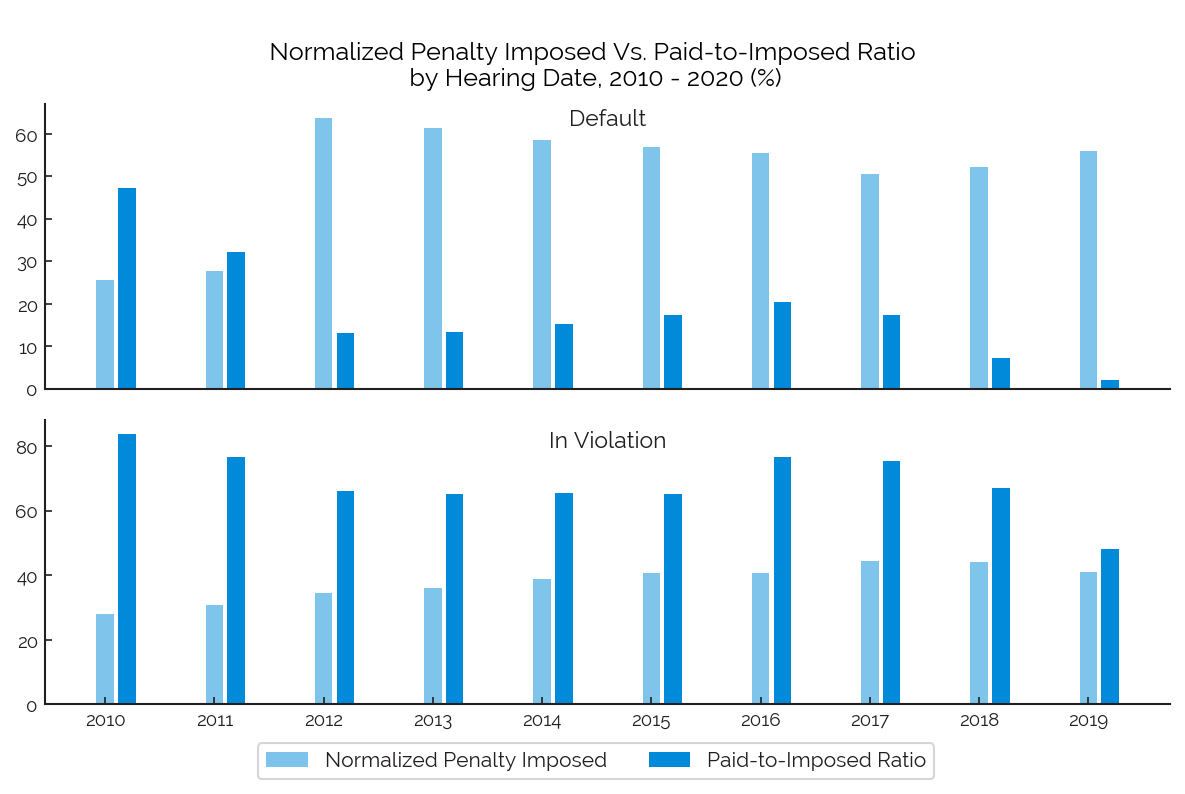

In [86]:
fig, axs = plt.subplots(2, 1)
x1 = np.linspace(0,9,(2019-2010)+1)*5
x2 = np.linspace(0,9,(2019-2010)+1)*5+1

axs[0].bar(x1,
           hearing_status_to_plot.norm_penalty_imposed.DEFAULT, 
           color = nt_blue, 
           alpha = 0.5, 
           label = 'Norm Penalty - DEFAULT')
axs[0].bar(x2,
           hearing_status_to_plot.paid_to_imposed.DEFAULT,  
           color = nt_blue, 
           alpha = 1, 
           label = 'Paid-to-Imposed - DEFAULT')

ttl = axs[0].set_title('Default',pad=1)

ttl.set_position([.5, 0.92])

axs[1].bar(x1,
       hearing_status_to_plot.norm_penalty_imposed['IN VIOLATION'], 
       color = nt_blue, 
       alpha = 0.5,
       label = 'Normalized Penalty Imposed')

axs[1].bar(x2,
       hearing_status_to_plot.paid_to_imposed['IN VIOLATION'], 
       color = nt_blue, 
       alpha = 1, 
       label = 'Paid-to-Imposed Ratio')
ttl2 = axs[1].set_title('In Violation',pad=-2)
ttl2.set_position([.5, 0.92])

label = axs[1].set_xticks(ticks= x1)
axs[1].set_xticklabels(hearing_status_to_plot.index)



for i, ax in enumerate(axs.flat):
    if i < 1:
        ax.xaxis.set_major_locator(plt.NullLocator())
    else:
        xticks = ax.xaxis.get_major_ticks()
# lab = plt.ylabel("Number of Violations (k)")

lab = plt.xlabel(None)

l = plt.legend(loc='center left', 
           bbox_to_anchor=(.18, -0.2),
           fancybox=True,
           shadow=False, 
           ncol=2)


t= plt.figtext(0.5, .925, "\n Normalized Penalty Imposed Vs. Paid-to-Imposed Ratio \n by Hearing Date, 2010 - 2020 (%)",
               fontsize='large', color='black', ha ='center')
plt.subplots_adjust(hspace=.5)
plt.tight_layout()
# plt.subplots_adjust(top=0.88)
savefig("normalized_and_paid_to_imposed_hearing.png", fig, bottom=.1,top=0.9
       )

**Notes:**
- `Pending` ECB violations 
- `Default` violations seem to be the biggest driver in sharply decreasing in 2018 and 2019. `Default` violations have extremely low paid to imposed ratio in 2018 and 2019 with a very high normalized imposed penalty. This indicates that more people who do not show up in the hearing and also do not pay for their imposed penalty.
- `In Violation`: What is  this? def: 


In [87]:
hearing_status_to_plot

norm_penalty_imposed                      paid_to_imposed  \
hearing_status                 DEFAULT IN VIOLATION PENDING         DEFAULT   
hearing_date_year                                                             
2010                             25.51        28.01    0.00       47.331942   
2011                             27.81        30.61    0.00       32.292685   
2012                             63.81        34.48     NaN       12.990414   
2013                             61.53        35.99    0.00       13.259809   
2014                             58.49        38.80     NaN       15.162875   
2015                             56.91        40.68     NaN       17.305822   
2016                             55.47        40.58     NaN       20.369180   
2017                             50.55        44.49    0.15       17.456943   
2018                             52.20        43.93    0.00        7.293300   
2019                             55.98        41.03    0.02        1.920283   

                                           
hearing_status    IN VIOLATION    PENDING  
hearing_date_year                          
2010                 83.879752   0.000000  
2011                 76.571753        NaN  
2012                 66.180775        NaN  
2013                 65.115844        NaN  
2014                 65.441868        NaN  
2015                 65.235467        NaN  
2016                 76.469220        NaN  
2017                 75.371549  66.340226  
2018                 66.892905        NaN  
2019                 48.058794   2.270424

# 6.0 hearing-issuance date delta analysis

In [88]:
days_diff_2019_by_hearing = hearing_date_table.loc[hearing_date_table.hearing_date_year == 2019, "diff_hear_issue"]

In [89]:
quantile_2019 = days_diff_2019_by_hearing[
                    days_diff_2019_by_hearing > 0].quantile([0, .05, .1, .25, .5, .75, .9, .95, .99, .999, .9999, 1])
quantile_2019 = quantile_2019.to_frame()
quantile_2019.columns = ["2019"]

In [90]:
days_diff_2018_by_hearing = hearing_date_table.loc[hearing_date_table.hearing_date_year == 2018, "diff_hear_issue"]

In [91]:
days_diff_2017_by_hearing = hearing_date_table.loc[hearing_date_table.hearing_date_year == 2017, "diff_hear_issue"]

In [92]:
quantile_2018 = days_diff_2018_by_hearing[
                    days_diff_2018_by_hearing> 0].quantile([0, .05, .1, .25, .5, .75, .9, .95, .99, .999, .9999, 1])

In [93]:
quantile_2018 = quantile_2018.to_frame()
quantile_2018.columns = ["2018"]

In [94]:
quantile_2017 = days_diff_2017_by_hearing[
                    days_diff_2017_by_hearing > 0].quantile([0, .05, .1, .25, .5, .75, .9, .95, .99, .999, .9999, 1])

In [95]:
quantile_2017 = quantile_2017.to_frame()
quantile_2017.columns = ["2017"]

In [96]:
quantile = quantile_2017.join(quantile_2018).join(quantile_2019).reset_index()

In [97]:
quantile['index'] = quantile['index']*100

In [98]:
quantile.rename(columns = {'index':'quantiles'},inplace=True)

In [99]:
quantile = quantile.set_index('quantiles')

In [100]:
quantile

,2017,2018,2019
quantiles,,,
0.00,12.0000,1.0000,1.000
5.00,45.0000,46.0000,49.000
10.00,47.0000,48.0000,53.000
25.00,49.0000,54.0000,69.000
50.00,68.0000,86.0000,105.000
75.00,133.0000,158.0000,175.000
90.00,212.0000,246.0000,253.000
95.00,272.0000,311.0000,320.000
99.00,697.0000,668.9700,634.000


In [101]:
days_diff_2018_by_hearing.max()

9639

In [102]:
to_plot = hearing_date_table[["diff_hear_issue","hearing_date_year"]].groupby(['hearing_date_year']).agg([np.mean,np.median])
to_plot.columns = to_plot.columns.droplevel()

In [103]:
# to_plot['to_plt_lower_band'] = to_plot[["mean","median"]].apply(lambda x: x["mean"] if x["mean"] < x["std"] else x["std"], axis=1)

In [104]:
# to_plot['to_plt_upper_band'] = to_plot["std"]

In [105]:
# to_plot['lower_band'] = to_plot[["mean","std"]].apply(lambda x: max(x["mean"] - x["std"], 0), axis=1)

In [106]:
# to_plot['upper_band'] = to_plot[["mean","std"]].apply(lambda x: x["mean"] + x["std"], axis=1)

In [107]:
to_plot = to_plot.loc[2000:2019]

In [108]:
to_plot

,mean,median
hearing_date_year,,
2000,140.609901,74
2001,159.895876,90
2002,162.271387,70
2003,150.907231,70
2004,163.295384,68
2005,149.485777,63
2006,144.881281,63
2007,161.831988,67
2008,159.534562,62


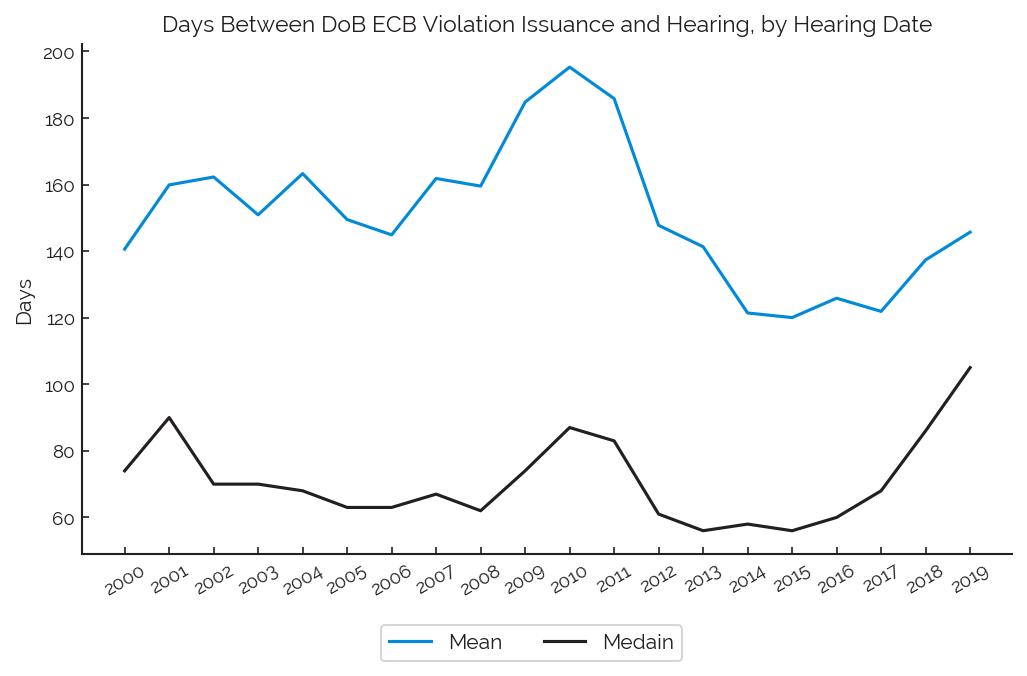

In [109]:
fig, ax = plt.subplots()

# by hearing date

plt.plot(to_plot.index, to_plot['mean'],color = nt_blue, label = 'Mean')
plt.plot(to_plot.index, to_plot['median'],color = nt_black, label = 'Medain')
tl = ax.set_xticklabels(to_plot.index,rotation=30)
t = ax.set_xticks(to_plot.index )
y_l = ax.set_ylabel("Days")
title = ax.set_title('Days Between DoB ECB Violation Issuance and Hearing, by Hearing Date')
ax.legend(
          loc='center left', 
          bbox_to_anchor=(0.31, -0.175),
          fancybox=True,
          shadow=False, 
          ncol=2)

savefig("ecb_hearing_imposed_daysdelta.png", fig, bottom=.2)

In [110]:
to_plot

,mean,median
hearing_date_year,,
2000,140.609901,74
2001,159.895876,90
2002,162.271387,70
2003,150.907231,70
2004,163.295384,68
2005,149.485777,63
2006,144.881281,63
2007,161.831988,67
2008,159.534562,62


# 7.0 City DOB Expense yearly VS Penalties

In [111]:
exp_dir = os.path.join(os.path.join(os.getcwd(),'../../nyc_dob_violations'),'data')
exp_actual_df = pd.read_csv(os.path.join(exp_dir,'Expense_Actuals.csv'))
dob_expense = exp_actual_df[exp_actual_df['AGENCY NAME'] == 'Department of Buildings']

In [112]:
dob_expense.columns

Index(['PUBLICATION DATE', 'FISCAL YEAR', 'AGENCY CODE', 'AGENCY NAME',
       'ALL FUNDS', 'CITY FUND', 'REMARK'],
      dtype='object')

- ALL FUNDS:Number,Total expense actuals,Dollars in Thousands
- CITY FUND:Number,City funded expense actuals, Dollars in Thousands

In [113]:
dob_expense = dob_expense[['FISCAL YEAR','ALL FUNDS']].reset_index().drop(columns = 'index')

In [114]:
dob_expense

,FISCAL YEAR,ALL FUNDS
0,2002,56378
1,2003,57862
2,2004,57895
3,2005,64273
4,2006,81526
5,2007,87195
6,2008,99410
7,2009,109678
8,2010,101530
9,2011,98974


In [115]:
dob_expense['expense_total'] = dob_expense['ALL FUNDS']*1000
dob_expense.drop(columns = 'ALL FUNDS',inplace = True)

In [116]:
ecb_penalty_penality_imposed_hear = violations_ecb_penalties_year_agg(
                                                agg_method_or_methods=[np.sum],
                                                filter_year=2000,
                                                to_group_by="hearing_date_year")['penality_imposed'].loc[2000:2019]


ecb_penalty_penality_imposed_hear.columns = ['imposed_total']


ecb_penalty_penality_paid_hear = violations_ecb_penalties_year_agg(
                                                agg_method_or_methods=[np.sum],
                                                filter_year=2000,
                                                to_group_by="hearing_date_year")['amount_paid'].loc[2000:2019]
ecb_penalty_penality_paid_hear.columns = ['paid_total']

In [117]:
total_penalties_df = ecb_penalty_penality_imposed_hear.join(ecb_penalty_penality_paid_hear)

In [118]:
total_penalties_df['penalty_unpaid'] = total_penalties_df.imposed_total - total_penalties_df.paid_total

In [119]:
to_plot = dob_expense.set_index(['FISCAL YEAR']).join(total_penalties_df)

In [120]:
to_plot = to_plot/1000000

In [121]:
to_plot = to_plot[['penalty_unpaid','imposed_total','expense_total']]

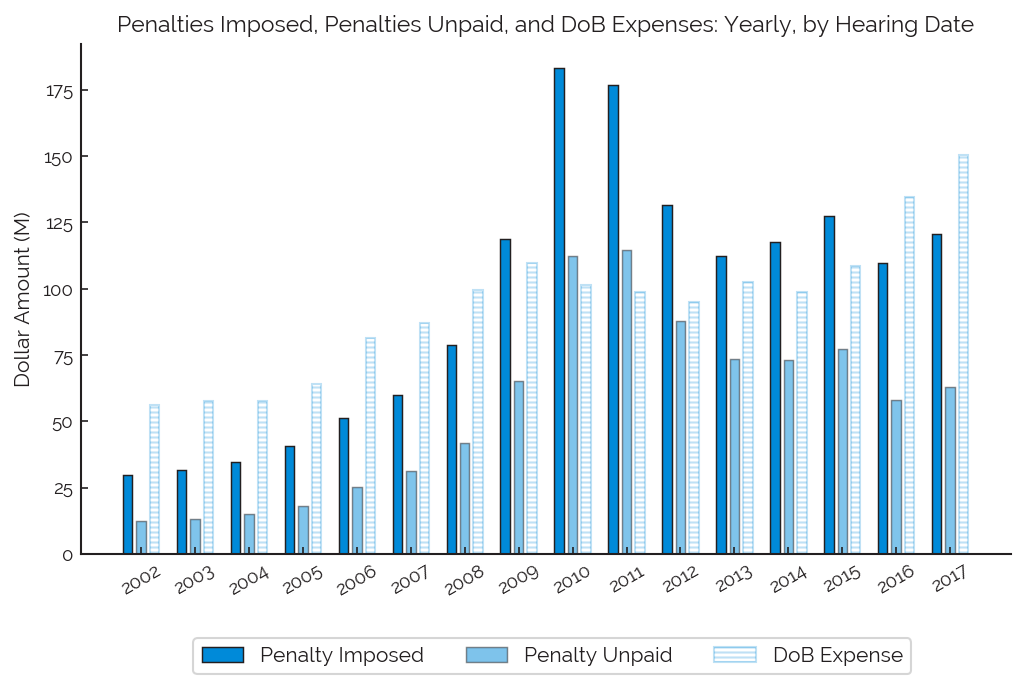

In [122]:
# ticks
fig, ax = plt.subplots()

x1 = np.linspace(0,15,(2017-2002)+1)*4
x2 = np.linspace(0,15,(2017-2002)+1)*4+1
x3 = np.linspace(0,15,(2017-2002)+1)*4+2
x4 = np.linspace(0,15,(2017-2002)+1)*4+3
x = [x1,x2,x3,x4]
labels = ['Penalty Imposed','Penalty Unpaid', 'DoB Expense']
# plotting

plt.bar(x= x[0],
        height=to_plot.imposed_total, 
        width = 0.7, linewidth = 0.7,
        color=nt_blue,
        edgecolor = nt_black,
        label = labels[0], 
        alpha = 1)
plt.bar(x= x[1],
        height=to_plot.penalty_unpaid, 
        width = 0.7, linewidth = 0.7,
        color=nt_blue,
        edgecolor = nt_black,
        label = labels[1], 
        alpha = .5)
plt.bar(x= x[2],
        height=to_plot.expense_total, 
        width = 0.7, 
        linewidth = 1,
        hatch = '-----',
#         hatch = '///////////',
        color='white',
        edgecolor = nt_blue,
        label = labels[2], 
        alpha = .25)
# legend
l = plt.legend(loc='center left', 
           bbox_to_anchor=(.11, -0.2),
           fancybox=True,
           shadow=False, 
           ncol=3)

#label
plt.xticks(ticks=x2, labels=to_plot.index,rotation=30)
lab = plt.ylabel("Dollar Amount (M)")
lab = plt.xlabel(None)

title= plt.title('Penalties Imposed, Penalties Unpaid, and DoB Expenses: Yearly, by Hearing Date')

savefig("total_exp_imposed_paid.png", fig, bottom=.2)

In [123]:
to_plot

,penalty_unpaid,imposed_total,expense_total
FISCAL YEAR,,,
2002,12.587589,29.833850,56.378
2003,13.167918,31.848017,57.862
2004,15.238749,34.560425,57.895
2005,18.190307,40.769893,64.273
2006,25.252732,51.281448,81.526
2007,31.263537,60.095966,87.195
2008,41.800358,78.751320,99.410
2009,65.133895,118.775649,109.678
2010,112.184911,183.044131,101.530
